In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/1884-2021-adana/1984_2021.csv
/kaggle/input/hocas-clean-dataset/eman.csv


In [2]:
#import Liberaries
import pandas as pd
import numpy as np
import math
import keras
import tensorflow as tf
#plots
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from matplotlib import pyplot
#models
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional,SimpleRNN
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
import xgboost as xgb
#evaluation
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
import time
#Tuner
import keras_tuner
from kerastuner.tuners import RandomSearch, BayesianOptimization, Hyperband
from kerastuner.engine.hyperparameters import HyperParameters
from pickle import dump,load
import warnings
warnings.simplefilter("ignore", UserWarning)
#fix seeds
np.random.seed(42)
tf.random.set_seed(42)
pd.set_option('max_columns', None)
e=1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [3]:
#import the dataset
url= '/kaggle/input/hocas-clean-dataset/eman.csv'

data= pd.read_csv(url,sep=',')
data.set_index('Date',inplace=True)
data.fillna( method ='ffill', inplace = True)


In [4]:
#declare global variables
xscaler = MinMaxScaler(feature_range = (0, 1))
yscaler = MinMaxScaler(feature_range = (0, 1))


In [5]:
#EVALUATE THE MODEL
def evaluate(y_pred,y_test):
    
    #DATA DENORMALIZATION
    y_test= yscaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred= yscaler.inverse_transform(y_pred.reshape(-1, 1))

    #CALCULATE R2
    from sklearn.metrics import r2_score
    r2= r2_score(y_test, y_pred)*100

    #CALCULATE MAPE
    from sklearn.metrics import mean_absolute_percentage_error
    mape= mean_absolute_percentage_error(y_test,y_pred)*100

    #CALCULATE MAE
    from sklearn.metrics import mean_absolute_error
    nmae= (mean_absolute_error(y_test,y_pred))/ np.mean(y_test)*100

    #CALCULATE RMSE
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    
    #CALCULATE nRMSE
    nrmse= rmse/ np.mean(y_test)*100
    
    #print(r2,mape,nmae,nrmse)
    print(' R2= %.3f' % r2 , 'MAPE= %.3f' % mape , 'nMAE= %.3f' % nmae ,
          'nRMSE= %.3f' % nrmse  )

In [6]:
#PLOT THE RESULTS
def plot(y_pred,y_test):
    #DATA DENORMALIZATION
    y_test= yscaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred= yscaler.inverse_transform(y_pred.reshape(-1, 1))
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(16,6))
    
    plt.legend(['Original',  'Prediction'], loc='upper right')
    date= pd.date_range(start='1/1/2021', end='31/12/2021')
    df = pd.DataFrame({'date': date})
    df = df.set_index('date')
    y_test_plot= y_test[-365:]
    y_pred_plot= y_pred[-365:]
    df = pd.DataFrame(y_test_plot, columns = ['Original'], index=date)
    df2 = pd.DataFrame(y_pred_plot, columns = ['Column_B'], index=date)
    df['Prediction'] = df2['Column_B']
    

    plt.xlabel('Time Interval', fontsize=18)
    plt.ylabel('GHI (Wh/m$^2$) ', fontsize=18)
    plt.plot(df['Original'], linestyle= 'dotted')
    plt.plot(df['Prediction'])
    plt.legend(['Original',  'Prediction'], loc='upper right')

    plt.show()

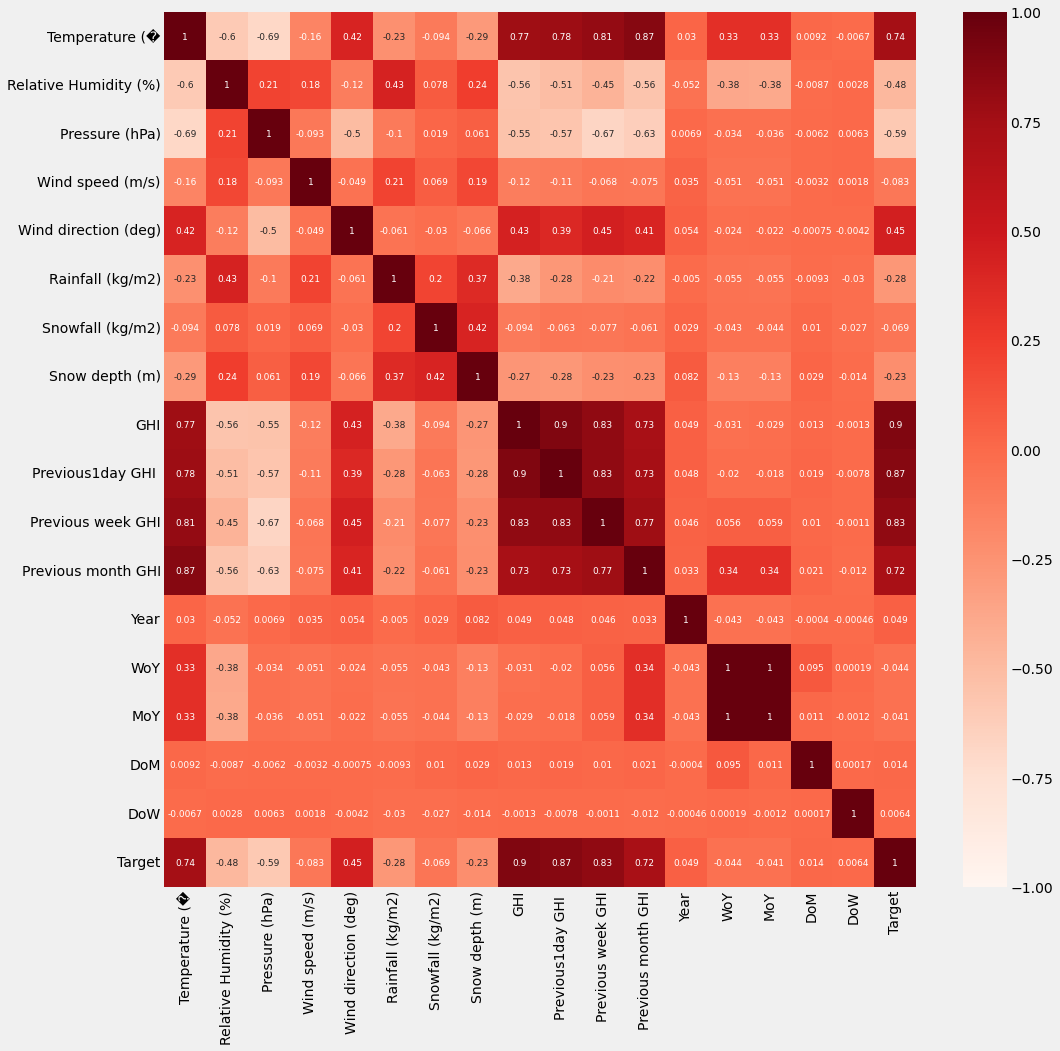

Relative Humidity (%)   -0.561878
Pressure (hPa)          -0.547156
Rainfall (kg/m2)        -0.384175
Snow depth (m)          -0.268701
Wind speed (m/s)        -0.124803
Snowfall (kg/m2)        -0.094202
WoY                     -0.031458
MoY                     -0.029120
DoW                     -0.001260
DoM                      0.013238
Year                     0.049019
Wind direction (deg)     0.433324
Previous month GHI       0.733267
Temperature (�           0.768524
Previous week GHI        0.830737
Target                   0.897113
Previous1day GHI         0.897130
GHI                      1.000000
Name: GHI, dtype: float64


In [7]:
def correlation(data):
    #Using Pearson Correlation
    plt.figure(figsize=(15,15))
    cor = data.corr()
    sns.heatmap(cor,vmin=-1, vmax=1, annot=True, cmap=plt.cm.Reds, annot_kws={"size": 9})
    plt.savefig('correlation.png', bbox_inches='tight')
    plt.show()
correlation(data)
GHI_corr=data.corr()['GHI']
print(GHI_corr.sort_values(ascending=True))

In [ ]:
epoch=500
patience=20
verbose= 1

def results(model):
    import time
    start = time.time()
    model =keras.models.load_model(model)
    history = model.fit(x_train,y_train,
                        verbose=verbose, epochs=epoch, 
                        validation_data=(x_test,y_test),
                      callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', 
                                                                  patience=patience)])


    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('model train vs validation loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper right')
    pyplot.show()
    
    #feature importance according to weights
    weights= model.get_weights()
    #print(weights)
    model.summary()
    # Get the models predicted values 
    y_pred = model.predict(x_test)
    print("Total time: ", time.time() - start, "seconds")
    evaluate(y_pred,y_test)
    #plot_model(model, to_file='mlp_plot.png', show_shapes=True, show_layer_names=True)
    plot(y_pred,y_test)

    

In [ ]:
#define the scenarios with different thresholds according to their correlation

scenario_1= data #threshold= 0

scenario_2= data.drop(['Snowfall (kg/m2)', 'Year', 'WoY', 'MoY', 'DoM', 'DoW'],
                      axis=1) #threshold= 0.1

scenario_3= scenario_2.drop(['Wind speed (m/s)'], axis=1) #threshold= 0.25

scenario_4= scenario_3.drop([  'Wind direction (deg)', 'Rainfall (kg/m2)',
                             'Snow depth (m)' ], axis=1) #threshold= 0.5


In [ ]:
scenario_1.shape,scenario_2.shape,scenario_3.shape,scenario_4.shape,

In [ ]:
#select scenario to be tuned
scenarios= [scenario_1,scenario_2,scenario_3,scenario_4]
#for s in scenarios:
    #data= s
data= scenario_1

In [ ]:

from sklearn.preprocessing import MinMaxScaler
xscaler = MinMaxScaler(feature_range = (0, 1))
yscaler = MinMaxScaler(feature_range = (0, 1))

y=data.iloc[:, -1].values
x= data.iloc[:, :-2].values

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

x_train= xscaler.fit_transform(x_train)
x_test= xscaler.transform(x_test)

y_train= yscaler.fit_transform(y_train.reshape(-1, 1))
y_test= yscaler.transform(y_test.reshape(-1, 1))

   

In [ ]:
#TRAIN MLR MODEL
def mlrm(x_train,y_train,x_test,y_test):
    mlr= LinearRegression(copy_X= True, fit_intercept= True, n_jobs= True, positive= False)
    start= time.time()
    mlr.fit(x_train,y_train)
    
    mlr_pred= mlr.predict(x_test)

    #MLR RESULTS
    print('MLR RESULTS')
    print("Total time: ", time.time() - start, "seconds")
    evaluate(mlr_pred,y_test)
    plot(mlr_pred,y_test)
    
mlrm(x_train, y_train, x_test, y_test)

In [ ]:
#tuning the MLP
def build_mlp_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('input_unit',min_value=2,max_value=200,step=2),
                    activation=hp.Choice('activation', values=['relu','tanh','sigmoid']),
                    kernel_initializer=hp.Choice('kernel_initializer', 
                                                 values=['GlorotNormal','GlorotUniform',
                                                         'HeNormal'])))
    for i in range(hp.Int('n_layers', 0, 2)):
        model.add(Dense(hp.Int(f'dense_{i}_units',min_value=2,max_value=100,step=2),
                       activation=hp.Choice('activation', values=['relu','tanh','sigmoid']),
                       kernel_initializer=hp.Choice('kernel_initializer', 
                                                 values=['GolortNormal','GlorotUniform',
                                                         'HeNormal'])))
  
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(1))
   
    
    # Compile the model
    opt= tf.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-1]))
    model.compile(optimizer=opt,loss='mse')
    
    model.fit(x_train,y_train,batch_size=hp.Choice("batch_size",
                                                   [8,16,32,64,128,256,512]))

    return model



tuner = BayesianOptimization(
    build_mlp_model,
    objective=keras_tuner.Objective("loss", direction="min"),
    max_trials=50,
    overwrite=True,

)

tuner.search( x=x_train,y=y_train, epochs=e,validation_data=(x_test,y_test),
             callbacks=[tf.keras.callbacks.EarlyStopping('loss', patience=10)])

best_hyperparameters= tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

best_mlp_model = tuner.get_best_models(num_models=1)[0]
print(best_mlp_model.summary())

#save the model
best_mlp_model.save("mlp_model_4")
results('mlp_model_4')

 


In [ ]:
#make the input 3D
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [ ]:
#tuning the RNN
def build_rnn_model(hp):
    model = Sequential()
    model.add(SimpleRNN(hp.Int('input_unit',min_value=2,max_value=100,step=2),
                    activation=hp.Choice('activation', values=['relu','tanh','sigmoid']),
                    kernel_initializer=hp.Choice('kernel_initializer', 
                                                 values=['GlorotNormal','GlorotUniform',
                                                         'HeNormal']),return_sequences=True))
    
    for i in range(hp.Int('n_layers', 0, 2)):
        model.add(SimpleRNN(hp.Int(f'rnn_{i}_units',min_value=2,max_value=200,step=2),
                       activation=hp.Choice('activation', values=['relu','tanh','sigmoid']),
                       kernel_initializer=hp.Choice('kernel_initializer', 
                                                 values=['GolortNormal','GlorotUniform',
                                                         'HeNormal']),return_sequences=True))
        
    
    
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(SimpleRNN(1,return_sequences=False))
   
    
    # Compile the model
    opt= tf.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-1]))
    model.compile(optimizer=opt,loss='mse')
    
    model.fit(x_train,y_train,batch_size=hp.Choice("batch_size",
                                                   [8,16,32,64,128,256,512]))

    return model


    
tuner = BayesianOptimization(
    build_rnn_model,
    objective=keras_tuner.Objective("loss", direction="min"),
    max_trials=50,
    overwrite=True,

)

tuner.search( x=x_train,y=y_train, epochs=e,validation_data=(x_test,y_test),
             callbacks=[tf.keras.callbacks.EarlyStopping('loss', patience=10)])

best_hyperparameters= tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

best_rnn_model = tuner.get_best_models(num_models=1)[0]
print(best_rnn_model.summary())

#save the model
best_rnn_model.save("rnn_model_4")
results('rnn_model_4')



In [ ]:
#tuning the LSTM
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=2,max_value=200,step=2),
                    activation=hp.Choice('activation', values=['relu','tanh','sigmoid']),
                    kernel_initializer=hp.Choice('kernel_initializer', 
                    values=['GlorotNormal','GlorotUniform',
                            'HeNormal']),return_sequences=True))
    
    for i in range(hp.Int('n_layers', 0, 2)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=2,max_value=100,step=2),
                       activation=hp.Choice('activation',
                        values=['relu','tanh','sigmoid']),
                       kernel_initializer=hp.Choice('kernel_initializer', 
                        values=['GolortNormal','GlorotUniform','HeNormal']),
                       return_sequences=True))
        
    
    
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(LSTM(1,return_sequences=False))
   
    
    # Compile the model
    opt= tf.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-1]))
    model.compile(optimizer=opt,loss='mse')
    
    model.fit(x_train,y_train,batch_size=hp.Choice("batch_size",
                                                   [8,16,32,64,128,256,512]))

    return model


    
tuner = BayesianOptimization(
    build_lstm_model,
    objective=keras_tuner.Objective("loss", direction="min"),
    max_trials=50,
    overwrite=True,
    
)

tuner.search( x=x_train,y=y_train, epochs=e,validation_data=(x_test,y_test),
             callbacks=[tf.keras.callbacks.EarlyStopping('loss', patience=10)])

best_hyperparameters= tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

best_lstm_model = tuner.get_best_models(num_models=1)[0]
print(best_lstm_model.summary())

best_lstm_model.save("lstm_model_4")
results('lstm_model_4')



In [ ]:
#tuning the GRU
def build_gru_model(hp):
    model = Sequential()
    model.add(GRU(hp.Int('input_unit',min_value=2,max_value=200,step=2),
                    activation=hp.Choice('activation', values=['relu','tanh','sigmoid']),
                    kernel_initializer=hp.Choice('kernel_initializer', 
                                                 values=['GlorotNormal','GlorotUniform',
                                                         'HeNormal']),return_sequences=True))
    
    for i in range(hp.Int('n_layers', 0, 2)):
        model.add(GRU(hp.Int(f'gru_{i}_units',min_value=2,max_value=100,step=2),
                       activation=hp.Choice('activation', values=['relu','tanh','sigmoid']),
                       kernel_initializer=hp.Choice('kernel_initializer', 
                                                 values=['GolortNormal','GlorotUniform',
                                                         'HeNormal']),return_sequences=True))
        
   
    
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(GRU(1,return_sequences=False))
   
    
    # Compile the model
    opt= tf.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-1]))
    model.compile(optimizer=opt,loss='mse')
    
    model.fit(x_train,y_train,batch_size=hp.Choice("batch_size",
                                                   [8,16,32,64,128,256,512]))

    return model


    
tuner = BayesianOptimization(
    build_gru_model,
    objective=keras_tuner.Objective("loss", direction="min"),
    max_trials=50,
    overwrite=True,
    
)

tuner.search( x=x_train,y=y_train, epochs=e,validation_data=(x_test,y_test),
             callbacks=[tf.keras.callbacks.EarlyStopping('loss', patience=10)])

best_hyperparameters= tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

best_gru_model = tuner.get_best_models(num_models=1)[0]
print(best_gru_model.summary())

best_gru_model.save("gru_model_4")
results('gru_model_4')



In [ ]:
#tuning the BiLSTM
def build_bilstm_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(hp.Int('input_unit',min_value=2,max_value=200,step=2),
                    activation=hp.Choice('activation', values=['relu','tanh','sigmoid']),
                    kernel_initializer=hp.Choice('kernel_initializer', 
                                                 values=['GlorotNormal','GlorotUniform',
                                                         'HeNormal']),return_sequences=True)))
    
    for i in range(hp.Int('n_layers', 0, 2)):
        model.add(Bidirectional(LSTM(hp.Int(f'gru_{i}_units',min_value=2,max_value=100,step=2),
                       activation=hp.Choice('activation', values=['relu','tanh','sigmoid']),
                       kernel_initializer=hp.Choice('kernel_initializer', 
                                                 values=['GolortNormal','GlorotUniform',
                                                         'HeNormal']),return_sequences=True)))
        
   
    
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(LSTM(1,return_sequences=False))
   
    
    # Compile the model
    opt= tf.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-1]))
    model.compile(optimizer=opt,loss='mse')
    
    model.fit(x_train,y_train,batch_size=hp.Choice("batch_size",
                                                   [8,16,32,64,128,256,512]))

    return model


    
tuner = BayesianOptimization(
    build_bilstm_model,
    objective=keras_tuner.Objective("loss", direction="min"),
    max_trials=50,
    overwrite=True,
    
)

tuner.search( x=x_train,y=y_train, epochs=e,validation_data=(x_test,y_test),
             callbacks=[tf.keras.callbacks.EarlyStopping('loss', patience=10)])

best_hyperparameters= tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

best_bilstm_model = tuner.get_best_models(num_models=1)[0]
print(best_bilstm_model.summary())

#save the model
best_bilstm_model.save("bilstm_model_4")
results('bilstm_model_4')



In [ ]:
#tuning the BiGRU
def build_bigru_model(hp):
    model = Sequential()
    model.add(Bidirectional(GRU(hp.Int('input_unit',min_value=2,max_value=100,step=2),
                    activation=hp.Choice('activation', values=['relu','tanh','sigmoid']),
                    kernel_initializer=hp.Choice('kernel_initializer', 
                                                 values=['GlorotNormal','GlorotUniform',
                                                         'HeNormal']),return_sequences=True)))
    
    for i in range(hp.Int('n_layers', 0, 2)):
        model.add(Bidirectional(GRU(hp.Int(f'gru_{i}_units',min_value=2,max_value=100,step=2),
                       activation=hp.Choice('activation', values=['relu','tanh','sigmoid']),
                       kernel_initializer=hp.Choice('kernel_initializer', 
                                                 values=['GolortNormal','GlorotUniform',
                                                         'HeNormal']),return_sequences=True)))
        
    
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(GRU(1,return_sequences=False))
   
    
    # Compile the model
    opt= tf.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-1]))
    model.compile(optimizer=opt,loss='mse')
    
    model.fit(x_train,y_train,batch_size=hp.Choice("batch_size",
                                                   [8,16,32,64,128,256,512]))

    return model


    
tuner = BayesianOptimization(
    build_bigru_model,
    objective=keras_tuner.Objective("loss", direction="min"),
    max_trials=50,
    overwrite=True,
    
)

tuner.search( x=x_train,y=y_train, epochs=e,validation_data=(x_test,y_test),
             callbacks=[tf.keras.callbacks.EarlyStopping('loss', patience=10)])

best_hyperparameters= tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

best_bigru_model = tuner.get_best_models(num_models=1)[0]
print(best_bigru_model.summary())

#save the model
best_bigru_model.save("bigru_model_4")
results('bigru_model_4')

